In [17]:
from scipy import io
from scipy.signal import butter, lfilter
import h5py
import random
import numpy as np
import os

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load training data

In [19]:
chunks_matfile = io.loadmat('chunks_gb/ksenia_long_1.mat')
data_g = chunks_matfile['chunks_good']
data_b = chunks_matfile['chunks_bad']

data = np.concatenate((data_g, data_b))
print(data.shape)

(40230, 24, 250)


In [20]:
labels = np.zeros((data.shape[0],2))

labels[0:data_g.shape[0],0] = 1
labels[data_b.shape[0]:,1] = 1

print(sum(labels))

[ 20115.  20115.]


# Load validation data

In [21]:
chunks_matfile = io.loadmat('chunks_gb/ksenia_long_2val.mat')
data_g = chunks_matfile['chunks_good']
data_b = chunks_matfile['chunks_bad']

data_val = np.concatenate((data_g, data_b))
print(data_val.shape)

labels_val = np.zeros((data_val.shape[0],2))

labels_val[0:data_g.shape[0],0] = 1
labels_val[data_b.shape[0]:,1] = 1

print(sum(labels_val))

(13324, 24, 250)
[ 6662.  6662.]


In [22]:
data_val.shape

(13324, 24, 250)

In [23]:
data_val_slice = data_val[0,:,:]
data_val_slice.shape

(24, 250)

In [8]:
#window=('tukey', 0.25), nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')[source]¶

In [24]:
from scipy import signal

In [25]:
f, t, Sxx = signal.spectrogram(data, 250, nperseg=32, nfft=None, axis = 2)

In [26]:
f, t, Sxx_val = signal.spectrogram(data_val, 250, nperseg=32, nfft=None, axis = 2)

In [27]:
f.shape

(17,)

In [28]:
t.shape

(8,)

In [ ]:
Sxx.shape

In [32]:
Sxx = np.swapaxes(Sxx,1,3)
Sxx_val = np.swapaxes(Sxx_val,1,3)

In [34]:
Sxx = np.swapaxes(Sxx,1,2)
Sxx_val = np.swapaxes(Sxx_val,1,2)

In [35]:
Sxx.shape
Sxx_val.shape

(13324, 17, 8, 24)

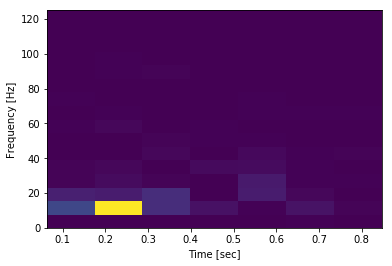

In [36]:
plt.pcolormesh(t, f, Sxx[0,:,:,0])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [37]:
input_size = Sxx.shape[1:]

In [38]:
input_size

(17, 8, 24)

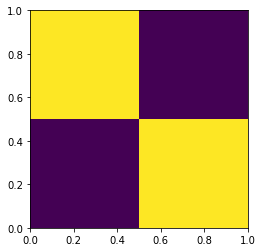

In [39]:
plt.imshow(labels_val, extent=[0, 1, 0, 1])

In [40]:
data_b.shape

(6662, 24, 250)

In [41]:
data_g.shape

(6662, 24, 250)

In [42]:
from keras.layers import Convolution2D, Dense, Dropout, Input, merge, GlobalMaxPooling2D, MaxPooling2D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [43]:
#slice_len = 250

nb_filters = 10
kernel_size = 3

conv1d_act = "relu"

dense1_n = 20
dense1_act = "relu"

dense2_n = 20
dense2_act = "relu"

do = 0

path_to_save_model = 'testmodel'

In [44]:
input_seq = Input(shape=input_size)

convolved = Convolution2D(nb_filters, kernel_size, border_mode="same", activation=conv1d_act)(input_seq)
pooled = GlobalMaxPooling2D()(convolved)

dense1 = Dense(dense1_n, activation=dense1_act)(pooled)
dense1do = Dropout(do)(dense1)

dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
dense2do = Dropout(do)(dense2)

out = Dense(2, activation='softmax')(dense2do)

model = Model(input=input_seq, output=out)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

from keras.callbacks import EarlyStopping, ModelCheckpoint

#nb_epoch = 100000
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_categorical_accuracy', verbose=1,
                               save_best_only=True, mode='auto', period=1)

samples_per_epoch = 3000
nb_epoch = 30



C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, 3, activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [45]:
history = model.fit(Sxx, labels, validation_data=(Sxx_val,labels_val), batch_size=32, epochs=100, verbose=1,)

Train on 40230 samples, validate on 13324 samples
Epoch 1/100
40230/40230 [==============================] - 13s - loss: 0.3949 - categorical_accuracy: 0.8235 - val_loss: 0.7398 - val_categorical_accuracy: 0.7999
Epoch 2/100
40230/40230 [==============================] - 9s - loss: 0.1445 - categorical_accuracy: 0.9489 - val_loss: 0.8845 - val_categorical_accuracy: 0.8019
Epoch 3/100
40230/40230 [==============================] - 12s - loss: 0.1060 - categorical_accuracy: 0.9652 - val_loss: 0.6851 - val_categorical_accuracy: 0.8135
Epoch 4/100
40230/40230 [==============================] - 9s - loss: 0.0658 - categorical_accuracy: 0.9768 - val_loss: 0.9154 - val_categorical_accuracy: 0.8117
Epoch 5/100
40230/40230 [==============================] - 10s - loss: 0.0527 - categorical_accuracy: 0.9818 - val_loss: 0.9421 - val_categorical_accuracy: 0.8184
Epoch 6/100
40230/40230 [==============================] - 11s - loss: 0.0462 - categorical_accuracy: 0.9834 - val_loss: 1.0135 - val_cat

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.570405). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285702). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 10s - loss: 0.0144 - categorical_accuracy: 0.9954 - val_loss: 1.6386 - val_categorical_accuracy: 0.8027
Epoch 28/100
40230/40230 [==============================] - 9s - loss: 0.0137 - categorical_accuracy: 0.9964 - val_loss: 1.5406 - val_categorical_accuracy: 0.8082
Epoch 29/100
40230/40230 [==============================] - 11s - loss: 0.0087 - categorical_accuracy: 0.9971 - val_loss: 1.4134 - val_categorical_accuracy: 0.8077
Epoch 30/100
40230/40230 [==============================] - 9s - loss: 0.0078 - categorical_accuracy: 0.9975 - val_loss: 1.5349 - val_categorical_accuracy: 0.8026
Epoch 31/100
40230/40230 [==============================] - 9s - loss: 0.0095 - categorical_accuracy: 0.9974 - val_loss: 1.6721 - val_categorical_accuracy: 0.7835
Epoch 32/100
40230/40230 [==============================] - 12s - loss: 0.0118 - categorical_accuracy: 0.9964 - val_loss: 1.3646 - val_categorical_accuracy: 0.8311
Epoch 33/100
40230/40230 [======

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.422297). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211649). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 10s - loss: 0.0119 - categorical_accuracy: 0.9968 - val_loss: 1.0541 - val_categorical_accuracy: 0.8308
Epoch 47/100
40230/40230 [==============================] - 9s - loss: 0.0084 - categorical_accuracy: 0.9975 - val_loss: 1.4502 - val_categorical_accuracy: 0.8229
Epoch 48/100
40230/40230 [==============================] - 11s - loss: 0.0070 - categorical_accuracy: 0.9980 - val_loss: 1.9084 - val_categorical_accuracy: 0.7913
Epoch 49/100
40230/40230 [==============================] - 9s - loss: 0.0015 - categorical_accuracy: 0.9996 - val_loss: 2.0998 - val_categorical_accuracy: 0.7881
Epoch 50/100
40230/40230 [==============================] - 9s - loss: 0.0136 - categorical_accuracy: 0.9969 - val_loss: 1.8735 - val_categorical_accuracy: 0.7902
Epoch 51/100
40230/40230 [==============================] - 11s - loss: 0.0064 - categorical_accuracy: 0.9980 - val_loss: 1.7159 - val_categorical_accuracy: 0.8018
Epoch 52/100
40230/40230 [======

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.978691). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.555393). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132095). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 10s - loss: 0.0049 - categorical_accuracy: 0.9984 - val_loss: 1.5188 - val_categorical_accuracy: 0.8260
Epoch 60/100
40230/40230 [==============================] - 9s - loss: 0.0107 - categorical_accuracy: 0.9972 - val_loss: 1.3737 - val_categorical_accuracy: 0.8193
Epoch 61/100
40230/40230 [==============================] - 12s - loss: 0.0063 - categorical_accuracy: 0.9983 - val_loss: 1.6417 - val_categorical_accuracy: 0.7948
Epoch 62/100
40230/40230 [==============================] - 9s - loss: 0.0055 - categorical_accuracy: 0.9987 - val_loss: 1.8508 - val_categorical_accuracy: 0.7949
Epoch 63/100
40230/40230 [==============================] - 9s - loss: 0.0059 - categorical_accuracy: 0.9979 - val_loss: 1.9279 - val_categorical_accuracy: 0.7861
Epoch 64/100
40230/40230 [==============================] - 11s - loss: 0.0036 - categorical_accuracy: 0.9990 - val_loss: 1.8373 - val_categorical_accuracy: 0.8126
Epoch 65/100
40230/40230 [======

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.526373). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.314222). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102071). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 10s - loss: 0.0027 - categorical_accuracy: 0.9991 - val_loss: 1.8934 - val_categorical_accuracy: 0.8019
Epoch 96/100
40230/40230 [==============================] - 9s - loss: 0.0093 - categorical_accuracy: 0.9986 - val_loss: 1.0279 - val_categorical_accuracy: 0.8324
Epoch 97/100
40230/40230 [==============================] - 11s - loss: 0.0050 - categorical_accuracy: 0.9985 - val_loss: 2.0655 - val_categorical_accuracy: 0.7765
Epoch 98/100
40230/40230 [==============================] - 9s - loss: 3.1525e-04 - categorical_accuracy: 0.9999 - val_loss: 2.3646 - val_categorical_accuracy: 0.7738
Epoch 99/100
40230/40230 [==============================] - 10s - loss: 0.0063 - categorical_accuracy: 0.9978 - val_loss: 2.2851 - val_categorical_accuracy: 0.7525
Epoch 100/100
40230/40230 [==============================] - 11s - loss: 0.0081 - categorical_accuracy: 0.9988 - val_loss: 1.1868 - val_categorical_accuracy: 0.8091


In [ ]:
model.save('mo')

# Visualization draft

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
#from vis.utils.vggnet import VGG16
from vis.visualization import *

In [ ]:
model.summary()

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass_m(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter_m(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
layer_name = 'dense_3'
numtops = 1

tops = np.zeros([numtops,21])

for j in range(numtops):

    layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

    idx = 0;
    img = visualize_class_activation(model, layer_idx, filter_indices=idx, max_iter=1)

    from mne.viz import plot_topomap
    import numpy as np
    from scipy.io import loadmat

    img = butter_bandpass_filter_m(img.T,10,12,250,5).T
    img_sum = np.sum(img,axis = 0)
    testmat = loadmat('chanlocs')

    ifvis = testmat['ifvis']
    ifvis = ifvis[0]
    ifvis = (ifvis == 1)

    chanlocs = testmat['chanlocs_xy'].T

    chanlocs_m = chanlocs[:,[-1,-2]]
    chanlocs_m[:,-2] = -chanlocs_m[:,-2]

    img_sum_vis = img_sum[ifvis]

    tops[j,:] = img_sum_vis